## 数据处理与读取

In [36]:
import numpy as np
import random
from PIL import Image

class DataProcessor():
    # 初始化
    def __init__(self, use_poster=False):
        self.use_poster = use_poster
        
        # 声明数据文件路径
        user_info_path = '../datasets/ml-1m/users.dat'
        movie_info_path = '../datasets/ml-1m/movies.dat'
        if use_poster:
            rating_info_path = '../datasets/ml-1m/new_rating.txt'
        else:
            rating_info_path = '../datasets/ml-1m/ratings.dat'
        self.post_path = '../datasets/ml-1m/posters/'
        
        # 记录用户数据的最大ID
        self.max_user_id = 0
        self.max_user_age = 0
        self.max_user_job = 0
        
        # 获取用户数据
        self.user_info = self.get_user_info(user_info_path)
        
        # 获取电影数据
        self.movie_info, self.movie_titles, self.movie_cats = self.get_movie_info(movie_info_path)
        
        # 记录电影的最大ID
        self.max_movie_id = np.max(list(map(int, self.movie_info.keys())))
        self.max_movie_title = np.max([self.movie_titles[k] for k in self.movie_titles])
        self.max_movie_cat = np.max([self.movie_cats[k] for k in self.movie_cats])
        
        # 获取评分数据
        self.rating_info = self.get_rating_info(rating_info_path)
        
        # 构建数据集
        self.dataset = self.get_dataset(user_info=self.user_info, 
                                       movie_info=self.movie_info, rating_info=self.rating_info)
        
        # 划分数据集
        self.train_dataset = self.dataset[:int(len(self.dataset) * 0.9)]
        self.test_dataset = self.dataset[int(len(self.dataset) * 0.9):]
        
        # 打印测试
        print('用户数据量：{}，电影数据量：{}'.format(len(self.user_info), len(self.movie_info)))
        print('构建的数据集总量：{}，其中训练集：{}，测试集：{}'.format(len(self.dataset), 
                                                   len(self.train_dataset), len(self.test_dataset)))
        
    # 获取用户数据
    def get_user_info(self, path):
        def gender2num(gender):
            return 1 if gender == 'F' else 0

        with open(path, 'r') as f:
            data = f.readlines()

        user_info = {}
        
        for item in data:
            item = item.strip().split('::')
            user_id = item[0]
            user_info[user_id] = {
                'user_id': int(user_id),
                'gender': gender2num(item[1]),
                'age': int(item[2]),
                'job': int(item[3])
            }
            self.max_user_id = max(self.max_user_id, int(user_id))
            self.max_user_age = max(self.max_user_age, int(item[2]))
            self.max_user_job = max(self.max_user_job, int(item[3]))

        return user_info
    
    # 获取电影数据
    def get_movie_info(self, path):
        with open(path, 'r', encoding='ISO-8859-1') as f:
            data = f.readlines()

        # 建立3个字典，分别存放电影的所有、名称、类别信息
        movie_info, movie_titles, movie_cats = {}, {}, {}

        # 对电影名称、类别中不同的单词计数
        t_count, c_count = 1, 1

        # 按行读取数据并处理
        for item in data:
            item = item.strip().split('::')
            v_id = item[0]
            v_title = item[1][:-7]  # 去除title里的上映年份
            v_year = item[1][-5:-1] # 获取上映年份
            v_cat = item[2].split('|')

            # 统计电影名称包含的单词，并给每个单词一个序号，存放在movie_titles中
            titles = v_title.split()
            for t in titles:
                if t not in movie_titles:
                    movie_titles[t] = t_count
                    t_count += 1

            # 统计电影类别包含的单词，并给每个单词一个序号，存放在movie_cat中
            for c in v_cat:
                if c not in movie_cats:
                    movie_cats[c] = c_count
                    c_count += 1

            # 补0使电影名称对应的列表长度为15（最长的电影名称长度为15）
            title = [movie_titles[k] for k in titles]
            while len(title) < 15:
                title.append(0)

            # 补0使电影类别对应的列表长度为6（最多类别为6）
            cat = [movie_cats[k] for k in v_cat]
            while len(cat) < 6:
                cat.append(0)

            # 保存电影完整信息
            movie_info[v_id] = {
                'movie_id': int(v_id),
                'title': title,
                'cat': cat,
                'year': int(v_year)
            }

        return movie_info, movie_titles, movie_cats
    
    # 获取评分数据
    def get_rating_info(self, path):
        with open(path, 'r') as f:
            data = f.readlines()

        rating_info = {}

        for item in data:
            item = item.strip().split('::')
            user_id, movie_id, score = item[0], item[1], item[2]
            if user_id not in rating_info.keys():
                rating_info[user_id] = {movie_id: float(score)}
            else:
                rating_info[user_id][movie_id] = float(score)

        return rating_info
    
    # 构建数据集
    def get_dataset(self, user_info, movie_info, rating_info):
        dataset = []

        # 按照评分数据的key值索引数据
        for user_id in rating_info.keys():
            user_ratings = rating_info[user_id]
            for movie_id in user_ratings:
                dataset.append({
                    'user_info': user_info[user_id],
                    'movie_info': movie_info[movie_id],
                    'score': user_ratings[movie_id]
                })

        return dataset
    
    # 数据加载器
    def load_data(self, dataset=None, mode='train'):
        BATCHSIZE = 256  # 定义批次大小
        data_length = len(dataset)
        index_list = list(range(data_length))

        # 定义数据迭代加载器
        def data_generator():
            # 训练模式下，打乱训练数据
            if mode == 'train':
                random.shuffle(index_list)

            # 声明每个特征的列表
            user_id_list, user_gender_list, user_age_list, user_job_list = [], [], [], []
            movie_id_list, movie_title_list, movie_cat_list, movie_poster_list = [], [], [], []
            score_list = []

            # 按索引遍历输入数据集
            for idx, i in enumerate(index_list):
                # 获取特征数据并保存到对应特征列表中
                user_id_list.append(dataset[i]['user_info']['user_id'])
                user_gender_list.append(dataset[i]['user_info']['gender'])
                user_age_list.append(dataset[i]['user_info']['age'])
                user_job_list.append(dataset[i]['user_info']['job'])

                movie_id_list.append(dataset[i]['movie_info']['movie_id'])
                movie_title_list.append(dataset[i]['movie_info']['title'])
                movie_cat_list.append(dataset[i]['movie_info']['cat'])

                # 如果使用电影海报数据
                if self.use_poster:
                    movie_id = dataset[i]['movie_info']['movie_id']
                    poster = Image.open(poster_path + 'mov_id{}.jpg'.format(str(movie_id)))
                    poster = poster.resize([64, 64])
                    if len(poster.size) <= 2:
                        poster = poster.convert('RGB')

                    movie_poster_list.append(np.array(poster))

                score_list.append(int(dataset[i]['score']))

                # 如果读取到数据量达到定义的批次大小，则返回当前批次
                if len(user_id_list) == BATCHSIZE:
                    # 转换list到ndarray，并reshape到固定形状
                    user_id_arr = np.array(user_id_list)
                    user_gender_arr = np.array(user_gender_list)
                    user_age_arr = np.array(user_age_list)
                    user_job_arr = np.array(user_job_list)

                    movie_id_arr = np.array(movie_id_list)
                    movie_title_arr = np.reshape(np.array(movie_title_list), [BATCHSIZE, 1, 15]).astype(np.int64)
                    movie_cat_arr = np.reshape(np.array(movie_cat_list), [BATCHSIZE, 6]).astype(np.int64)

                    if self.use_poster:
                        movie_poster_arr = np.reshape(np.array(movie_poster_list)/127.5 - 1, 
                                                      [BATCHSIZE, 3, 64, 64]).astype(np.float32)
                    else:
                        movie_poster_arr = np.array([0.])

                    score_arr = np.reshape(np.array(score_list), [-1, 1]).astype(np.float32)

                    # 返回当前批次数据
                    yield [user_id_arr, user_gender_arr, user_age_arr, user_job_arr], \
                            [movie_id_arr, movie_title_arr, movie_cat_arr, movie_poster_arr], score_arr

                    # 清空数据
                    user_id_list, user_gender_list, user_age_list, user_job_list = [], [], [], []
                    movie_id_list, movie_title_list, movie_cat_list, movie_poster_list = [], [], [], []
                    score_list = []

        return data_generator

## 模型设计

电影推荐任务的神经网络模型设计，包含以下步骤：
1. 分别将用户、电影的多个特征数据转换成特征向量（Embedding层）。
2. 对这些特征向量，使用全连接层或卷积层进一步提取特征。
3. 将用户、电影多个数据的特征向量融合成一个向量表示，方便进行相似度计算。
4. 计算特征之间的相似度（余弦相似度，用该相似度和用户真实评分的均方误差作为该回归模型的损失函数）。

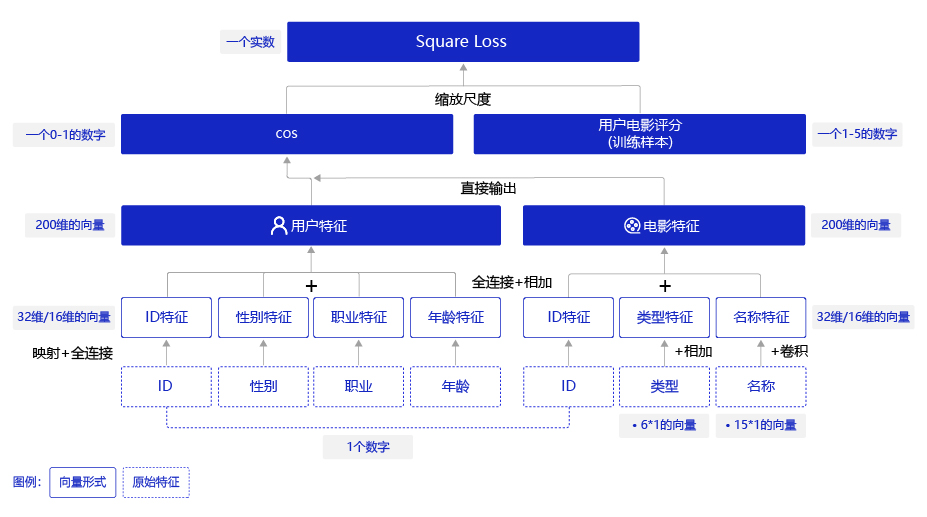

### Embedding层

Embedding是一个嵌入层，将输入的非负整数矩阵中的每个数值，转换为具有固定长度的向量。

Embedding层和Conv2D, Linear层一样，Embedding层也有可学习的权重，通过矩阵相乘的方法对输入数据进行映射。

Embedding中将输入映射成向量的基本步骤是：
1. 将输入数据转换成one-hot格式的向量；
2. one-hot向量和Embedding层的权重进行矩阵相乘得到Embedding的结果；

In [37]:
import paddle
import paddle.nn as nn
from paddle.nn import Linear, Embedding, Conv2D
import paddle.nn.functional as F

import numpy as np
import random
import math

In [38]:
# 声明用户的最大ID，在此基础上加1（算上数字0）
USER_ID_NUM = 6040 + 1

# 声明Embedding层，将ID映射为长度为32的向量
# @num_embedding 表示嵌入词典的大小
# @embedding_dim 表示每个嵌入向量的大小，即Embedding层的维度
user_emb = Embedding(num_embeddings=USER_ID_NUM, embedding_dim=32)  # 32是可自行调整的超参数

# 声明输入数据
arr = np.array([1], dtype='int64').reshape((-1))
print('原始输入数据：', arr)

# 转换为Tensor
ts = paddle.to_tensor(arr)
print('Tensor数据：', ts)

# 转换为向量
emb = user_emb(ts)
print('Embedding后的结果：', emb.numpy())
print('Embedding后的形状：', emb.shape)

原始输入数据： [1]
Tensor数据： Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
       [1])
Embedding后的结果： [[ 0.01806359  0.00376735  0.020603    0.00104769 -0.00963937  0.01746995
   0.02396753 -0.01780143 -0.00618581 -0.00054278  0.00308289  0.03045911
   0.00756031  0.00613675  0.00748995 -0.02939511  0.02532686  0.01581876
  -0.01137703  0.00248619 -0.02169476 -0.00485989 -0.02712538 -0.01205361
  -0.02213866  0.02983714 -0.02912552  0.0017532  -0.01072849  0.00411107
  -0.01064339  0.0206951 ]]
Embedding后的形状： [1, 32]


### 用户特征提取网络

在用户特征提取网络中，对每个用户数据做embedding处理，然后经过一个全连接层，使用ReLU激活函数，得到所有用户特征后，将特征整合，经过一个全连接层得到最终的用户数据特征，该特征的维度是200维，用于和电影特征计算相似度。

特征融合是一种常用的特征增强手段，通过结合不同特征的长处，达到取长补短的目的。常用的融合方法有：
- 特征（加权）相加
- 特征级联
- 特征正交

In [46]:
class UserModel(nn.Layer):
    def __init__(self, use_poster, use_mov_title, use_mov_cat, use_age_job, fc_sizes):
        super(UserModel, self).__init__()
        
        # 将传入的name信息和bool型参数添加到模型类中
        self.use_mov_poster = use_poster
        self.use_mov_title = use_mov_title
        self.use_usr_age_job = use_age_job
        self.use_mov_cat = use_mov_cat
        self.fc_sizes = fc_sizes
        
        # 使用上节定义的数据处理类，获取数据集的信息，并构建训练和验证集的数据迭代器
        Dataset = DataProcessor(self.use_mov_poster)
        self.Dataset = Dataset
        self.trainset = self.Dataset.train_dataset
        self.valset = self.Dataset.test_dataset
        self.train_loader = self.Dataset.load_data(dataset=self.trainset, mode='train')
        self.test_loader = self.Dataset.load_data(dataset=self.valset, mode='valid')
        
        """ define network layer for embedding usr info """
        USR_ID_NUM = Dataset.max_user_id + 1
        # 对用户ID做映射，并紧接着一个FC层
        self.usr_emb = Embedding(num_embeddings=USR_ID_NUM, embedding_dim=32)
        self.usr_fc = Linear(32, 32)
        
        # 对用户性别信息做映射，并紧接着一个FC层
        USR_GENDER_DICT_SIZE = 2
        self.usr_gender_emb = Embedding(num_embeddings=USR_GENDER_DICT_SIZE, embedding_dim=16)
        self.usr_gender_fc = Linear(16, 16)
        
        # 对用户年龄信息做映射，并紧接着一个FC层
        USR_AGE_DICT_SIZE = Dataset.max_user_age + 1
        self.usr_age_emb = Embedding(num_embeddings=USR_AGE_DICT_SIZE, embedding_dim=16)
        self.usr_age_fc = Linear(16, 16)
        
        # 对用户职业信息做映射，并紧接着一个FC层
        USR_JOB_DICT_SIZE = Dataset.max_user_job + 1
        self.usr_job_emb = Embedding(num_embeddings=USR_JOB_DICT_SIZE, embedding_dim=16)
        self.usr_job_fc = Linear(16, 16)
        
        # 新建一个FC层，用于整合用户数据信息
        self.usr_combined = Linear(80, 200)

        # 新建一个Linear层，用于整合电影特征
        self.mov_concat_embed = Linear(in_features=96, out_features=200)

        user_sizes = [200] + self.fc_sizes
        acts = ["relu" for _ in range(len(self.fc_sizes))]
        self._user_layers = []
        for i in range(len(self.fc_sizes)):
            linear = Linear(
                in_features=user_sizes[i],
                out_features=user_sizes[i + 1],
                weight_attr=paddle.ParamAttr(
                    initializer=nn.initializer.Normal(
                        std=1.0 / math.sqrt(user_sizes[i]))))
            # 向模型中添加了一个 paddle.nn.Linear 子层
            self.add_sublayer('linear_user_%d' % i, linear)
            self._user_layers.append(linear)
            if acts[i] == 'relu':
                act = nn.ReLU()
                # 向模型中添加了一个 paddle.nn.ReLU() 子层
                self.add_sublayer('user_act_%d' % i, act)
                self._user_layers.append(act)
    
    # 定义计算用户特征的前向运算过程
    def get_usr_feat(self, usr_var):
        # 获取到用户数据
        usr_id, usr_gender, usr_age, usr_job = usr_var
        
        # 将用户的ID数据经过embedding和FC计算，得到的特征保存在feats_collect中
        feats_collect = []
        usr_id = self.usr_emb(usr_id)
        usr_id = self.usr_fc(usr_id)
        usr_id = F.relu(usr_id)
        feats_collect.append(usr_id)
        
        # 计算用户的性别特征，并保存在feats_collect中
        usr_gender = self.usr_gender_emb(usr_gender)
        usr_gender = self.usr_gender_fc(usr_gender)
        usr_gender = F.relu(usr_gender)
        
        feats_collect.append(usr_gender)
        
        # 选择是否使用用户的年龄-职业特征
        if self.use_usr_age_job:
            # 计算用户的年龄特征，并保存在feats_collect中
            usr_age = self.usr_age_emb(usr_age)
            usr_age = self.usr_age_fc(usr_age)
            usr_age = F.relu(usr_age)
            feats_collect.append(usr_age)
            # 计算用户的职业特征，并保存在feats_collect中
            usr_job = self.usr_job_emb(usr_job)
            usr_job = self.usr_job_fc(usr_job)
            usr_job = F.relu(usr_job)
            feats_collect.append(usr_job)
        
        # 将用户的特征级联，并通过FC层得到最终的用户特征
        print([f.shape for f in feats_collect])
        usr_feat = paddle.concat(feats_collect, axis=1)
        user_features = F.tanh(self.usr_combined(usr_feat))
        
        #通过3层全链接层，获得用于计算相似度的用户特征和电影特征
        for n_layer in self._user_layers:
            user_features = n_layer(user_features)
        
        return user_features

In [47]:
# 测试用户特征提取网络
fc_sizes = [128, 64, 32]
model = UserModel(use_poster=False, use_mov_title=True, use_mov_cat=True, use_age_job=True, fc_sizes=fc_sizes)
model.eval()

用户数据量：6040，电影数据量：3883
构建的数据集总量：1000209，其中训练集：900188，测试集：100021


In [48]:
train_loader = model.train_loader

for idx, data in enumerate(train_loader()):
    user, movie, score = data
    
    user_v = [[var[0]] for var in user]
    print('输入的用户ID：{}\n性别：{}\n年龄：{}\n职业：{}'.format(*user_v))
    
    user_v = [paddle.to_tensor(np.array(var)) for var in user_v]
    user_feat = model.get_usr_feat(user_v)
    print('计算得到的用户特征维度：', user_feat.shape)
    print('用户融合后的特征：', user_feat)
    
    break

输入的用户ID：[1211]
性别：[0]
年龄：[18]
职业：[4]
[[1, 32], [1, 16], [1, 16], [1, 16]]
计算得到的用户特征维度： [1, 32]
用户融合后的特征： Tensor(shape=[1, 32], dtype=float32, place=Place(cpu), stop_gradient=False,
       [[0.01269822, 0.        , 0.        , 0.01664978, 0.        , 0.05955268,
         0.10572301, 0.        , 0.        , 0.        , 0.        , 0.02318716,
         0.05350569, 0.        , 0.11802208, 0.11553811, 0.10337201, 0.        ,
         0.        , 0.04008415, 0.01588181, 0.        , 0.        , 0.        ,
         0.00182443, 0.00003096, 0.02329502, 0.05006156, 0.        , 0.06946321,
         0.02218402, 0.        ]])


### 电影特征提取网络

In [57]:
class MovieModel(nn.Layer):
    def __init__(self, use_poster, use_mov_title, use_mov_cat, use_age_job,fc_sizes):
        super(MovieModel, self).__init__()
                
        # 将传入的name信息和bool型参数添加到模型类中
        self.use_mov_poster = use_poster
        self.use_mov_title = use_mov_title
        self.use_usr_age_job = use_age_job
        self.use_mov_cat = use_mov_cat
        self.fc_sizes = fc_sizes
        
        # 获取数据集的信息，并构建训练和验证集的数据迭代器
        Dataset = DataProcessor(self.use_mov_poster)
        self.Dataset = Dataset
        self.trainset = self.Dataset.train_dataset
        self.valset = self.Dataset.test_dataset
        self.train_loader = self.Dataset.load_data(dataset=self.trainset, mode='train')
        self.valid_loader = self.Dataset.load_data(dataset=self.valset, mode='valid')
        
        """ define network layer for embedding usr info """
        # 对电影ID信息做映射，并紧接着一个Linear层
        MOV_DICT_SIZE = Dataset.max_movie_id + 1
        self.mov_emb = Embedding(num_embeddings=MOV_DICT_SIZE, embedding_dim=32)
        self.mov_fc = Linear(32, 32)
        
        # 对电影类别做映射
        CATEGORY_DICT_SIZE = len(Dataset.movie_cats) + 1
        self.mov_cat_emb = Embedding(num_embeddings=CATEGORY_DICT_SIZE, embedding_dim=32)
        self.mov_cat_fc = Linear(32, 32)
        
        # 对电影名称做映射
        MOV_TITLE_DICT_SIZE = len(Dataset.movie_titles) + 1
        self.mov_title_emb = Embedding(num_embeddings=MOV_TITLE_DICT_SIZE, embedding_dim=32)
        self.mov_title_conv = Conv2D(in_channels=1, out_channels=1, kernel_size=(3, 1), stride=(2,1), padding=0)
        self.mov_title_conv2 = Conv2D(in_channels=1, out_channels=1, kernel_size=(3, 1), stride=1, padding=0)

        # 新建一个Linear层，用于整合电影特征
        self.mov_concat_embed = Linear(in_features=96, out_features=200)
        
        #电影特征和用户特征使用了不同的全连接层，不共享参数
        movie_sizes = [200] + self.fc_sizes
        acts = ["relu" for _ in range(len(self.fc_sizes))]
        self._movie_layers = []
        for i in range(len(self.fc_sizes)):
            linear = Linear(
                in_features=movie_sizes[i],
                out_features=movie_sizes[i + 1],
                weight_attr=paddle.ParamAttr(
                    initializer=nn.initializer.Normal(
                        std=1.0 / math.sqrt(movie_sizes[i]))))
            self.add_sublayer('linear_movie_%d' % i, linear)
            self._movie_layers.append(linear)
            if acts[i] == 'relu':
                act = nn.ReLU()
                self.add_sublayer('movie_act_%d' % i, act)
                self._movie_layers.append(act)
                
     # 定义电影特征的前向计算过程
    def get_mov_feat(self, mov_var):
        # 获得电影数据
        mov_id, mov_title, mov_cat, mov_poster = mov_var
        feats_collect = []
        
        # 获得batchsize的大小
        batch_size = mov_id.shape[0]
        
        # 计算电影ID的特征，并存在feats_collect中
        mov_id = self.mov_emb(mov_id)
        mov_id = self.mov_fc(mov_id)
        mov_id = F.relu(mov_id)
        feats_collect.append(mov_id)
        
        # 如果使用电影的种类数据，计算电影种类特征的映射
        if self.use_mov_cat:
            # 计算电影种类的特征映射，对多个种类的特征求和得到最终特征
            mov_cat = self.mov_cat_emb(mov_cat)
            print(mov_title.shape)
            mov_cat = paddle.sum(mov_cat, axis=1, keepdim=False)

            mov_cat = self.mov_cat_fc(mov_cat)
            feats_collect.append(mov_cat)

        if self.use_mov_title:
            # 计算电影名字的特征映射，对特征映射使用卷积计算最终的特征
            mov_title = self.mov_title_emb(mov_title)
            mov_title = F.relu(self.mov_title_conv2(F.relu(self.mov_title_conv(mov_title))))
            
            mov_title = paddle.sum(mov_title, axis=2, keepdim=False)
            mov_title = F.relu(mov_title)
            mov_title = paddle.reshape(mov_title, [batch_size, -1])
            feats_collect.append(mov_title)
            
        # 使用一个全连接层，整合所有电影特征，映射为一个200维的特征向量
        mov_feat = paddle.concat(feats_collect, axis=1)
        mov_features = F.tanh(self.mov_concat_embed(mov_feat))
        for n_layer in self._movie_layers:
            mov_features = n_layer(mov_features)
            
        return mov_features

In [58]:
# 测试电影特征提取网络
fc_sizes = [128, 64, 32]
model = MovieModel(use_poster=False, use_mov_title=True, use_mov_cat=True, use_age_job=True,fc_sizes=fc_sizes)
model.eval()

用户数据量：6040，电影数据量：3883
构建的数据集总量：1000209，其中训练集：900188，测试集：100021


In [61]:
train_loader = model.train_loader

for idx, data in enumerate(train_loader()):
    user, movie, score = data
    
    movie_v = [var[0:1] for var in movie]
    _movie_v = [np.squeeze(var[0:1]) for var in movie]
    print('输入的电影ID：{}\n名称：{}\n类别：{}'.format(*_movie_v))
    
    movie_v = [paddle.to_tensor(var) for var in movie_v]
    movie_feat = model.get_mov_feat(movie_v)
    print('计算得到的电影特征维度：', movie_feat.shape)
    print('融合后的电影特征：', movie_feat)
    
    break

输入的电影ID：3499
名称：[4735    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
类别：[11  0  0  0  0  0]
[1, 1, 15]
计算得到的电影特征维度： [1, 32]
融合后的电影特征： Tensor(shape=[1, 32], dtype=float32, place=Place(cpu), stop_gradient=False,
       [[0.        , 0.        , 0.22437304, 0.        , 0.11181665, 0.05222439,
         0.        , 0.        , 0.28028256, 0.        , 0.        , 0.        ,
         0.01911366, 0.        , 0.32832119, 0.06949088, 0.        , 0.        ,
         0.19756545, 0.        , 0.24353193, 0.        , 0.35128623, 0.29402992,
         0.28603384, 0.23730513, 0.29739681, 0.02424101, 0.17231096, 0.        ,
         0.00166493, 0.        ]])


### 相似度计算

- 计算向量距离（相似度）的常用方案：欧式距离、曼哈顿距离、切比雪夫距离、余弦相似度等
- 余弦相似度是通过计算两个向量的夹角余弦值来评估它们的相似度，角度为0时，余弦值为1，表示完全相似
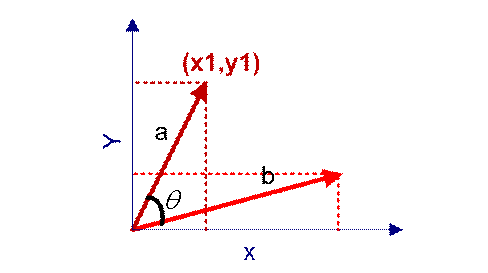

In [63]:
# 计算两个向量的余弦相似度
def similarity(user_feature, movie_feature):
    result = F.cosine_similarity(user_feature, movie_feature)
    result = paddle.scale(result, scale=5)
    return result

sim = similarity(user_feat, movie_feat)

# 此时的相似度值很小是因为：
# 神经网络还没有经过训练，模型参数都是随机初始化的，提取出的特征没有规律性
# 计算相似度的用户数据和电影数据相关性很小
sim

Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [1.35495293])

### 模型设计完整代码

In [69]:
class Model(nn.Layer):
    def __init__(self, use_poster, use_mov_title, use_mov_cat, use_age_job, fc_sizes):
        super(Model, self).__init__()
        
        # 将传入的name信息和bool型参数添加到模型类中
        self.use_mov_poster = use_poster
        self.use_mov_title = use_mov_title
        self.use_usr_age_job = use_age_job
        self.use_mov_cat = use_mov_cat
        self.fc_sizes = fc_sizes
        
        # 获取数据集的信息，并构建训练和验证集的数据迭代器
        Dataset = DataProcessor(self.use_mov_poster)
        self.Dataset = Dataset
        self.trainset = self.Dataset.train_dataset
        self.valset = self.Dataset.test_dataset
        self.train_loader = self.Dataset.load_data(dataset=self.trainset, mode='train')
        self.valid_loader = self.Dataset.load_data(dataset=self.valset, mode='valid')

        """ define network layer for embedding usr info """
        USR_ID_NUM = Dataset.max_user_id + 1
        # 对用户ID做映射，并紧接着一个Linear层
        self.usr_emb = Embedding(num_embeddings=USR_ID_NUM, embedding_dim=32, sparse=False)
        self.usr_fc = Linear(in_features=32, out_features=32)
        
        # 对用户性别信息做映射，并紧接着一个Linear层
        USR_GENDER_DICT_SIZE = 2
        self.usr_gender_emb = Embedding(num_embeddings=USR_GENDER_DICT_SIZE, embedding_dim=16)
        self.usr_gender_fc = Linear(in_features=16, out_features=16)
        
        # 对用户年龄信息做映射，并紧接着一个Linear层
        USR_AGE_DICT_SIZE = Dataset.max_user_age + 1
        self.usr_age_emb = Embedding(num_embeddings=USR_AGE_DICT_SIZE, embedding_dim=16)
        self.usr_age_fc = Linear(in_features=16, out_features=16)
        
        # 对用户职业信息做映射，并紧接着一个Linear层
        USR_JOB_DICT_SIZE = Dataset.max_user_job + 1
        self.usr_job_emb = Embedding(num_embeddings=USR_JOB_DICT_SIZE, embedding_dim=16)
        self.usr_job_fc = Linear(in_features=16, out_features=16)
        
        # 新建一个Linear层，用于整合用户数据信息
        self.usr_combined = Linear(in_features=80, out_features=200)
        
        """ define network layer for embedding usr info """
        # 对电影ID信息做映射，并紧接着一个Linear层
        MOV_DICT_SIZE = Dataset.max_movie_id + 1
        self.mov_emb = Embedding(num_embeddings=MOV_DICT_SIZE, embedding_dim=32)
        self.mov_fc = Linear(in_features=32, out_features=32)
        
        # 对电影类别做映射
        CATEGORY_DICT_SIZE = len(Dataset.movie_cats) + 1
        self.mov_cat_emb = Embedding(num_embeddings=CATEGORY_DICT_SIZE, embedding_dim=32, sparse=False)
        self.mov_cat_fc = Linear(in_features=32, out_features=32)
        
        # 对电影名称做映射
        MOV_TITLE_DICT_SIZE = len(Dataset.movie_titles) + 1
        self.mov_title_emb = Embedding(num_embeddings=MOV_TITLE_DICT_SIZE, embedding_dim=32, sparse=False)
        self.mov_title_conv = Conv2D(in_channels=1, out_channels=1, kernel_size=(3, 1), stride=(2,1), padding=0)
        self.mov_title_conv2 = Conv2D(in_channels=1, out_channels=1, kernel_size=(3, 1), stride=1, padding=0)
        
        # 新建一个FC层，用于整合电影特征
        self.mov_concat_embed = Linear(in_features=96, out_features=200)

        user_sizes = [200] + self.fc_sizes
        acts = ["relu" for _ in range(len(self.fc_sizes))]
        self._user_layers = []
        for i in range(len(self.fc_sizes)):
            linear = Linear(
                in_features=user_sizes[i],
                out_features=user_sizes[i + 1],
                weight_attr=paddle.ParamAttr(
                    initializer=nn.initializer.Normal(
                        std=1.0 / math.sqrt(user_sizes[i]))))
            self.add_sublayer('linear_user_%d' % i, linear)
            self._user_layers.append(linear)
            if acts[i] == 'relu':
                act = nn.ReLU()
                self.add_sublayer('user_act_%d' % i, act)
                self._user_layers.append(act)
                
        #电影特征和用户特征使用了不同的全连接层，不共享参数
        movie_sizes = [200] + self.fc_sizes
        acts = ["relu" for _ in range(len(self.fc_sizes))]
        self._movie_layers = []
        for i in range(len(self.fc_sizes)):
            linear = nn.Linear(
                in_features=movie_sizes[i],
                out_features=movie_sizes[i + 1],
                weight_attr=paddle.ParamAttr(
                    initializer=nn.initializer.Normal(
                        std=1.0 / math.sqrt(movie_sizes[i]))))
            self.add_sublayer('linear_movie_%d' % i, linear)
            self._movie_layers.append(linear)
            if acts[i] == 'relu':
                act = nn.ReLU()
                self.add_sublayer('movie_act_%d' % i, act)
                self._movie_layers.append(act)
                
    # 定义计算用户特征的前向运算过程
    def get_usr_feat(self, usr_var):
        """ get usr features"""
        # 获取到用户数据
        usr_id, usr_gender, usr_age, usr_job = usr_var
        # 将用户的ID数据经过embedding和Linear计算，得到的特征保存在feats_collect中
        feats_collect = []
        usr_id = self.usr_emb(usr_id)
        usr_id = self.usr_fc(usr_id)
        usr_id = F.relu(usr_id)
        feats_collect.append(usr_id)
        
        # 计算用户的性别特征，并保存在feats_collect中
        usr_gender = self.usr_gender_emb(usr_gender)
        usr_gender = self.usr_gender_fc(usr_gender)
        usr_gender = F.relu(usr_gender)
        feats_collect.append(usr_gender)
        # 选择是否使用用户的年龄-职业特征
        if self.use_usr_age_job:
            # 计算用户的年龄特征，并保存在feats_collect中
            usr_age = self.usr_age_emb(usr_age)
            usr_age = self.usr_age_fc(usr_age)
            usr_age = F.relu(usr_age)
            feats_collect.append(usr_age)
            # 计算用户的职业特征，并保存在feats_collect中
            usr_job = self.usr_job_emb(usr_job)
            usr_job = self.usr_job_fc(usr_job)
            usr_job = F.relu(usr_job)
            feats_collect.append(usr_job)
        
        # 将用户的特征级联，并通过Linear层得到最终的用户特征
        usr_feat = paddle.concat(feats_collect, axis=1)
        user_features = F.tanh(self.usr_combined(usr_feat))
        #通过3层全链接层，获得用于计算相似度的用户特征和电影特征
        for n_layer in self._user_layers:
            user_features = n_layer(user_features)

        return user_features
    
    # 定义电影特征的前向计算过程
    def get_mov_feat(self, mov_var):
        """ get movie features"""
        # 获得电影数据
        mov_id, mov_title, mov_cat, mov_poster = mov_var
        feats_collect = []
        # 获得batchsize的大小
        batch_size = mov_id.shape[0]
        # 计算电影ID的特征，并存在feats_collect中
        mov_id = self.mov_emb(mov_id)
        mov_id = self.mov_fc(mov_id)
        mov_id = F.relu(mov_id)
        feats_collect.append(mov_id)
        
        # 如果使用电影的种类数据，计算电影种类特征的映射
        if self.use_mov_cat:
            # 计算电影种类的特征映射，对多个种类的特征求和得到最终特征
            mov_cat = self.mov_cat_emb(mov_cat)
            mov_cat = paddle.sum(mov_cat, axis=1, keepdim=False)

            mov_cat = self.mov_cat_fc(mov_cat)
            feats_collect.append(mov_cat)

        if self.use_mov_title:
            # 计算电影名字的特征映射，对特征映射使用卷积计算最终的特征
            mov_title = self.mov_title_emb(mov_title)
            mov_title = F.relu(self.mov_title_conv2(F.relu(self.mov_title_conv(mov_title))))
            mov_title = paddle.sum(mov_title, axis=2, keepdim=False)
            mov_title = F.relu(mov_title)
            mov_title = paddle.reshape(mov_title, [batch_size, -1])
            feats_collect.append(mov_title)
            
        # 使用一个全连接层，整合所有电影特征，映射为一个200维的特征向量
        mov_feat = paddle.concat(feats_collect, axis=1)
        mov_features = F.tanh(self.mov_concat_embed(mov_feat))

        for n_layer in self._movie_layers:
            mov_features = n_layer(mov_features)

        return mov_features
    
    # 定义个性化推荐算法的前向计算
    def forward(self, usr_var, mov_var):
        # 计算用户特征和电影特征
        usr_feat = self.get_usr_feat(usr_var)
        mov_feat = self.get_mov_feat(mov_var)

        #通过3层全连接层，获得用于计算相似度的用户特征和电影特征
        for n_layer in self._user_layers:
            user_features = n_layer(user_features)

        for n_layer in self._movie_layers:
            mov_features = n_layer(mov_features)

        # 根据计算的特征计算相似度
        res = F.cosine_similarity(user_features, mov_features)
        
        # 将相似度扩大范围到和电影评分相同数据范围
        res = paddle.scale(res, scale=5)
        
        return usr_feat, mov_feat, res

In [72]:
# 测试
fc_sizes = [128, 64, 32]
model = Model(use_poster=False, use_mov_title=True, use_mov_cat=True, use_age_job=True, fc_sizes=fc_sizes)

用户数据量：6040，电影数据量：3883
构建的数据集总量：1000209，其中训练集：900188，测试集：100021
